# Netflix-IMDb Machine Learning Final Project
## Alyx Cleveland and Tony Barrows

Let's first download and gather our data for review.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

This is a very large data set, so let's dispense with it as quickly as we can. We need to download the *names* data set in order to get the primary key, merge on the *ratings* data set, and finally merge that again with the *netflix* data set.

In [2]:
def load_data_live():
    ''' Load Netflix data set from disk. Load IMDb data sets from IMDb website. Merge on title, write merged
    version to disk.'''
    nflix = pd.read_csv("../data/netflix_titles.csv")
    imdb_names = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", compression='gzip', delimiter = "\t",
                            low_memory = False)
    imdb_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", compression = 'gzip', delimiter = "\t",
                              low_memory = False)

    # just need the unique id 'tconst'
    imdb_names = imdb_names[['tconst', 'originalTitle']]
    imdb = imdb_ratings.merge(imdb_names, how = 'left', on = 'tconst')

    nflix = nflix.merge(imdb, how = 'left', left_on = 'title', right_on = 'originalTitle')
    nflix.to_csv("../data/nflix_merged.csv")
    
    return nflix

# only pull from by API if not on disk
try:
#    print('problem')
    nflix = pd.read_csv("../data/nflix_merged.csv")
except:
    nflix = load_data_live()

In [3]:
nflix = nflix.replace(['None', 'Not Reported', 'not reported', '', ' ', 'NaN'], np.nan, regex=True)
nflix.fillna(value=pd.np.nan, inplace=True)

nflix

<ipython-input-3-cf5d4a7e55f0>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  nflix.fillna(value=pd.np.nan, inplace=True)


,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,tconst,averageRating,numVotes,originalTitle
0,0,s1,NaN,3%,NaN,NaN,Brazil,NaN,2020,TV-MA,NaN,NaN,NaN,tt2096351,7.8,2053.0,3%
1,1,s1,NaN,3%,NaN,NaN,Brazil,NaN,2020,TV-MA,NaN,NaN,NaN,tt4922804,7.4,21771.0,3%
2,2,s2,Movie,7:19,NaN,NaN,Mexico,NaN,2016,TV-MA,NaN,NaN,NaN,tt5979312,6.0,567.0,7:19
3,3,s3,Movie,23:59,NaN,NaN,Singapore,NaN,2011,R,NaN,NaN,NaN,tt2100376,4.6,849.0,23:59
4,4,s4,Movie,9,NaN,NaN,NaN,NaN,2009,PG-13,NaN,NaN,NaN,tt0191312,6.0,73.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22408,22408,s7784,Movie,Zubaan,NaN,NaN,India,NaN,2015,TV-14,NaN,NaN,NaN,tt3776484,6.1,389.0,Zubaan
22409,22409,s7784,Movie,Zubaan,NaN,NaN,India,NaN,2015,TV-14,NaN,NaN,NaN,tt7368392,7.3,10.0,Zubaan
22410,22410,s7785,Movie,NaN,NaN,NaN,NaN,NaN,2019,TV-MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22411,22411,s7786,NaN,NaN,NaN,NaN,Australia,NaN,2019,TV-PG,NaN,NaN,NaN,tt7239256,6.9,1864.0,NaN


In [4]:
nflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22413 entries, 0 to 22412
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     22413 non-null  int64  
 1   show_id        22413 non-null  object 
 2   type           15001 non-null  object 
 3   title          8314 non-null   object 
 4   director       277 non-null    object 
 5   cast           22 non-null     object 
 6   country        7429 non-null   object 
 7   date_added     0 non-null      float64
 8   release_year   22413 non-null  int64  
 9   rating         22406 non-null  object 
 10  duration       0 non-null      float64
 11  listed_in      2142 non-null   object 
 12  description    0 non-null      float64
 13  tconst         20304 non-null  object 
 14  averageRating  20304 non-null  float64
 15  numVotes       20304 non-null  float64
 16  originalTitle  8180 non-null   object 
dtypes: float64(5), int64(2), object(10)
memory usage: 

In [5]:
nflix = nflix[nflix['averageRating'].isna() == False] 

y = nflix['averageRating'].values.ravel()
X = nflix.drop(columns=['averageRating', 'type'])

#X = nflix.drop(columns = ['numVotes', 'release_year'])

#X.info() #sanity check

print('Here!', nflix['averageRating'].isna().sum())

#for column in X:
#    X[column] = le.fit_transform(X[column])


#covMatrix = pd.DataFrame.cov(X)
#print(covMatrix)
#sn.heatmap(covMatrix, annot=True, fmt='g')
#plt.show()


Here! 0


In [6]:

def sepdata(nonan_imp):
    '''separates numerical and categorical variables into subsets
    quant and qual'''    
    for name in nonan_imp.columns:
        if type(nonan_imp[name][1]) == str:
            nonan_imp[name] = nonan_imp[name].astype(str)
        elif type(nonan_imp[name][1]) == int:
            #print(name)
            nonan_imp[name] = nonan_imp[name].astype(int)
        else:
            #nonan_imp[name] = pd.to_numeric(nonan_imp[name])
            nonan_imp[name] = nonan_imp[name].astype(str)

    quant = nonan_imp.select_dtypes(['number', 'float', 'int'])
    #print(quant.head)
    qual = nonan_imp.select_dtypes(['object'])
    #print(qual.head)
    return quant, qual

def prep():
    ''' produces a clean dataframe of X predictors and the y response 
    also encodes categorical variables'''
    fulldf = X
    ''' cut needs to be value between 0 and 1'''
    #nonan = dropcolna(fulldf, cut*len(fulldf))
    #nonan_imp = impute(nonan, 'most_frequent') #can use median here    
    quant, qual = sepdata(X)    
    #nona_enc = nonan_imp
    X_enc = X

    '''
    encoding catergorical variables
    '''    
    le = LabelEncoder()
    X_enc[qual.columns] = X_enc[qual.columns].apply(lambda
                col:le.fit_transform(col))    
#    print(nona_enc.head)    

    #y = y.values.ravel()
    
    return X


#quant, qual = sepdata(X)
X = prep()
#y = y.values.ravel()



def dropcolna(nonan):
    ''' takes full dataframe and drops columns with more missingness
    than the number, num, established by the cutoff later'''
    
    for feat in nonan.columns:
        if nonan[feat].isna().sum() > len(nonan):
            nonan.drop([feat], axis=1, inplace=True)
        else:
            '''sanity check for remaining nan'''
            print(feat, nonan[feat].isna().sum())
            pass
    print('new shape:', nonan.shape)
    return nonan

def impute(nonan):
    ''' imputes missing data by specified strategy, used 
    most frequent in this project'''
    values = nonan.values

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')    
    transformed_X = imp.fit_transform(X)    
    nonan_imp = pd.DataFrame(transformed_X, 
                             columns = [item for item in nonan.columns])
#    nonan_imp['days_to_death'] = y
    ''' sanity check to make sure there is no missingness left'''    
    print(nonan_imp)    
    for feat in nonan_imp:
        print('Here!', feat, nonan_imp[feat].isna().sum())
    return nonan_imp 
    
X = dropcolna(X)
X_imp = impute(X)

Unnamed: 0 0
show_id 0
title 0
director 0
cast 0
country 0
date_added 0
release_year 0
rating 0
duration 0
listed_in 0
description 0
tconst 0
numVotes 0
originalTitle 0
new shape: (20304, 15)
       Unnamed: 0  show_id  title  director  cast  country  date_added  \
0               0        0     14        39    11        6           0   
1               1        0     14        39    11        6           0   
2           10141      803     20        39    11       35           0   
3           13358     1612     13        39    11       46           0   
4           14344     2394     21        39    11       57           0   
...           ...      ...    ...       ...   ...      ...         ...   
20299       12559     5501   1345        39    11       57           0   
20300       12560     5501   1345        39    11       57           0   
20301       12561     5502   1346        39    11       24           0   
20302       12562     5502   1346        39    11       24          

In [7]:
X = X_imp

for feat in X_imp:
    print('Here!', feat, X_imp[feat].isna().sum())

Here! Unnamed: 0 0
Here! show_id 0
Here! title 0
Here! director 0
Here! cast 0
Here! country 0
Here! date_added 0
Here! release_year 0
Here! rating 0
Here! duration 0
Here! listed_in 0
Here! description 0
Here! tconst 0
Here! numVotes 0
Here! originalTitle 0


In [8]:
#Lasso Regression

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV


def lasso(X, y):
            
#    param_grid = {'alpha': [0.001, 0.01, 0.1, 1],
#                  'fit_intercept':[True, False],
#                  'normalize':[True, False],
#                  'tol': [1e-4, 1e-5, 1e-6], 
#                  'warm_start': [True, False],
#                  'selection': ['cyclic', 'random'],}
    
#    best_mod = GridSearchCV(linear_model.Lasso(),
#                            param_grid=param_grid,
#                            scoring='neg_mean_squared_error',cv=5,
#                            verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)

    param_grid = {'alpha': 0.001, 'fit_intercept': True, 'normalize': False,
                  'selection': 'random', 'tol': 0.0001, 'warm_start': True}

    best_mod = linear_model.Lasso(alpha=0.001, fit_intercept=True, normalize=False,
                                 selection = 'random', tol = 0.0001, warm_start=False)

    mod = best_mod.fit(X,y)    
    #print(best_mod.best_params_)    
    #mod = best_mod.best_estimator_

    
    imp = pd.Series(mod.coef_, index = X.columns)
    
    #imp = imp[(imp > 0.2) | (imp < -0.2)].sort_values()        

    print(imp)
    plt.rcParams.update({'font.size': 30, 'figure.figsize':(10, 20)})
    plt.gcf().subplots_adjust(left=0.3)
    
    plt.barh(X.columns, mod.coef_, color='red')
    plt.grid(color='gray', which='major', axis='y', linestyle='--', alpha=0.5)        
    plt.xlabel('Feature Importance')
    plt.savefig('../out/logreg_featimp.png', dpi = 400)
    plt.show()    
    
    return mod, imp.index


Unnamed: 0      -4.029695e-06
show_id          1.995837e-05
title           -5.181240e-05
director        -3.836840e-04
cast             1.055661e-01
country          2.461589e-03
date_added       0.000000e+00
release_year    -5.617633e-03
rating           1.197087e-02
duration         0.000000e+00
listed_in       -9.269069e-03
description      0.000000e+00
tconst           5.426136e-06
numVotes         1.156499e-05
originalTitle    5.282199e-07
dtype: float64


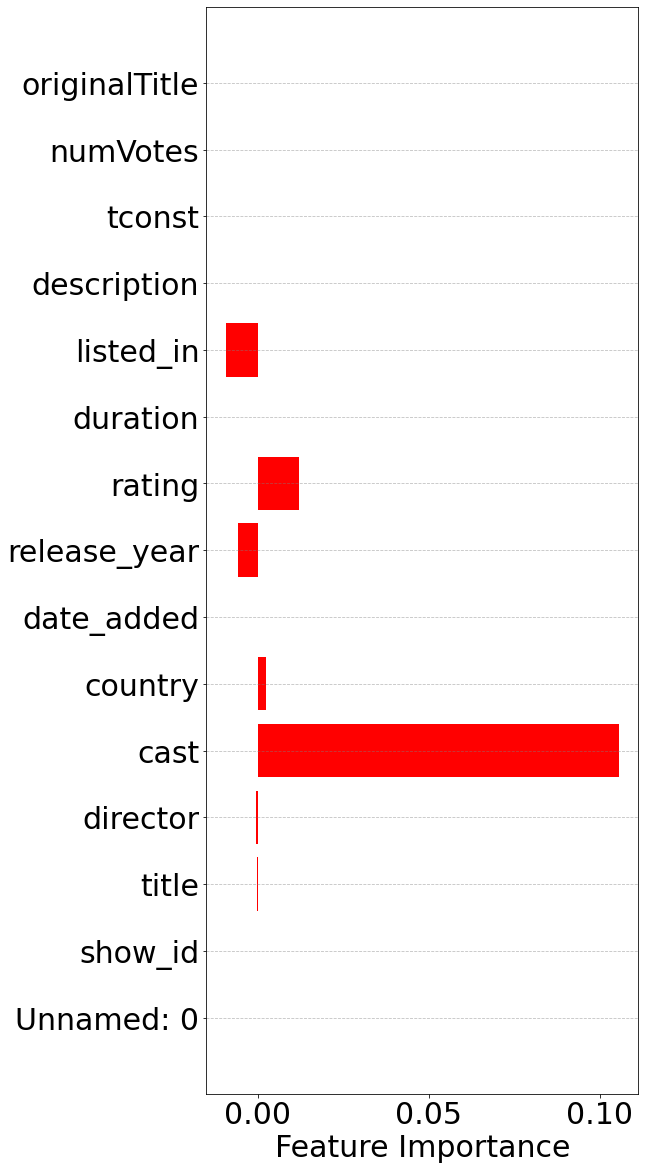

In [9]:
# mod, idx = lasso(X,y)
# X_limited = X[['title', 'director', 'cast', 'release_year', 'listed_in']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
mod, idx = lasso(x_train, y_train)

In [10]:
mod.score(x_test, y_test)

0.0005722087006420074